# Training our model
This notebook trains a model that takes a tweet as input and outputs a score between 0 and 1. 0 is negative sentiment, 0.5 is neutral sentiment, and 1 is positive sentiment.

We use TensorFlow to train our model; and Scikit-Learn, Numpy and Pandas for preparing training data. We use GLoVe word embeddings in our neural network. Our train and test data are from the Sentiment140 dataset.

The training data folder in Github is empty as we are having issues with Git LFS. We plan to resolve this later.

In [2]:
# Regular expressions
import re

# Data and visualization 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculations
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-02-01 22:03:11.682179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 22:03:12.198993: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-01 22:03:13.060077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/andalib/miniconda3/envs/tf/lib/
2023-02-01 22:03:13.060177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plug

In [3]:
df = pd.read_csv("data/train.csv", 
                      encoding="latin", 
                      header=None, 
                      names=["target","id","date","query","username","content"]
                     )

In [4]:
df.head()

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
print(f"Missing values: \n\n{df.isna().sum()}")

Missing values: 

target      0
id          0
date        0
query       0
username    0
content     0
dtype: int64


In [7]:
negative_samples = df[df["target"]==0]
print(f"Number of negative samples : {len(negative_samples)}\n")
negative_samples.head(5)

Number of negative samples : 800000



,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
neutral_samples = df[df["target"]==2]
print(f"Number of neutral samples : {len(neutral_samples)}\n\n")
neutral_samples.head(5)

Number of neutral samples : 0




,target,id,date,query,username,content


In [10]:
positive_samples = df[df["target"]==4]
print(f"Number of positive samples {len(positive_samples)}\n\n")
positive_samples.head(5)

Number of positive samples 800000




,target,id,date,query,username,content
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [11]:
data = [len(negative_samples), len(neutral_samples), len(positive_samples)]
labels = ["Negative","Neutral","Positive"]

In [12]:
colors = sns.color_palette("pastel")

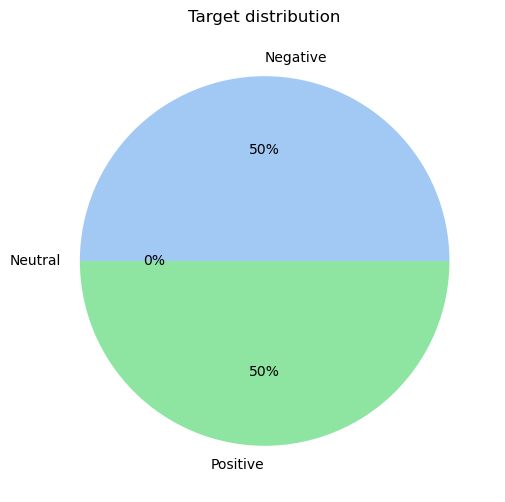

In [13]:
plt.figure(figsize=(6,6))
plt.title("Target distribution")
plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

In [15]:
df.drop(["id","date","query","username"],axis=1, inplace=True)

In [17]:
df.head(5)

,target,content
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [19]:
df.target = df.target.replace({4: 1})

In [20]:
df[df["target"]==1].head()

,target,content
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


## Preparing training data

In [21]:
regex_mentions = r"@[A-Za-z0-9_]+" # Remove mentions
regex_links = r"https?://[A-Za-z0-9./]+" # Remove links
regex_special = r"[^A-Za-z0-9]+" # Remove some special characters

In [23]:
# Apply the above
df.content = df.content.apply(lambda x: re.sub(regex_mentions, " ", str(x).strip()))
df.content = df.content.apply(lambda x: re.sub(regex_links, " ", str(x).strip()))
df.content = df.content.apply(lambda x: re.sub(regex_special, " ", str(x).strip()))

In [25]:
df.head(10) # Results

,target,content
0,0,Awww that s a bummer You shoulda got David Ca...
1,0,is upset that he can t update his Facebook by ...
2,0,I dived many times for the ball Managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am i h...
5,0,not the whole crew
6,0,Need a hug
7,0,hey long time no see Yes Rains a bit only a bi...
8,0,nope they didn t have it
9,0,que me muera


In [27]:
print(f"Null values: \n\n{df.isna().sum()}")

Null values: 

target     0
content    0
dtype: int64


In [29]:
train, test = train_test_split(df, test_size=0.1, random_state=44) # Split data into train and test set

In [30]:
print(f"Training set length: {len(train)/1e6}M examples")
print(f"Test set length: {len(test)/1e6}M examples")

Training set length: 1.44M examples
Test set length: 0.16M examples


In [31]:
'''
    Here we tokenize our data, i.e. split it into 'meaningful' parts. The Keras tokenizer represents each meaningful word as a vector of integers.
'''
tokenizer = Tokenizer()
# Updates the internal vocabulary based on our tweet contents
tokenizer.fit_on_texts(train.content)
# Setup the vocabular size based on the tokenizer results
vocab_size = len(tokenizer.word_index)+1


In [32]:
print(f"Word index length: {len(tokenizer.word_index)}")
print(f"Some words: {list(tokenizer.word_index.keys())[0:10]}")

Word index length: 268198
Some words: ['i', 'to', 'the', 'a', 'my', 'it', 'and', 'you', 'is', 'in']


In [34]:
# Intialize the max length to the first tweet length
max_length = len(df["content"][0].split())

# Loop through the tweets
for tweet in df["content"]: 
    # Get each tweet's length
    length = len(tweet.split())
    # Update the max length if greater
    if length > max_length: 
        max_length = length

print(f"Maximum token length: {max_length}")

Maximum token length: 53


In [35]:
sequences_train = tokenizer.texts_to_sequences(train.content) # Train data
sequences_test = tokenizer.texts_to_sequences(test.content) # Test data

In [36]:
# Pad the training and test sequences to the same length after the sequence
X_train = pad_sequences(sequences_train, maxlen=max_length, padding="post")
X_test = pad_sequences(sequences_test, maxlen=max_length, padding="post")

# Setup the training and test target values (sentiment scores)
y_train = train.target.values
y_test = test.target.values

print(f"Training test shape : {X_train.shape}")

Training test shape : (1440000, 53)


In [49]:
embeddings_dictionary = dict()
embedding_dimension = 100
glove_file = open("data/glove.6B.50d.txt")

In [47]:
print()

In [50]:
# Iterate through the glove file
for line in glove_file:
    # Split each line
    records = line.split()
    # Get the actual word
    word = records[0]
    # Get the dimensional representation
    representation = np.asarray(records[1:], dtype="float32")
    # Update the words dictionary 
    embeddings_dictionary[word] = representation
    
glove_file.close()

# Initialize the embedding_matrix
embeddings_matrix = np.zeros((vocab_size, embedding_dimension))

# Iterate through the tokenizer words list
for word, index in tokenizer.word_index.items():
    # Get the word representation
    embedding_vector = embeddings_dictionary.get(word)
    # Update the word representation if it exist in our dictionary
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

ValueError: could not broadcast input array from shape (50,) into shape (100,)

# Citations
We are grateful for the following source:
* https://www.kaggle.com/code/ibrahimserouis99/twitter-sentiment-analysis/notebook
* https://www.kaggle.com/datasets/kazanova/sentiment140
* https://www.tensorflow.org/api_docs/